# **Import Dependencies**

In [1]:
import numpy as np 
import pandas as pd
import os, re, pickle,pathlib
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Bidirectional, Dropout, BatchNormalization

In [2]:
seed = 42
val_size = 0.15
test_size = 0.15

data_dir = 'data/'
model_weights = 'GRUmodel.h5'
tflite_weights = 'GRUmodel.tflite'
tokenizer_path = 'tokenizer.pickle'

# **Data Preprocessing / Data Visualization / Data Storytelling**

In [3]:
#load data
def load_data():
    df_final = None
    
    projects = os.listdir(data_dir)
    for project in projects:
        project_dir = os.path.join(data_dir, project)
        priority_files = os.listdir(project_dir)
        for priority_file in priority_files:
            priority_file_path = os.path.join(project_dir, priority_file)
            df_pi = pd.read_csv(priority_file_path)
            if (df_final is None):
                df_final = df_pi
                
            else:
                df_final = pd.concat([df_final, df_pi])
                
    return df_final


df = load_data()
df = df[['Summary', 'Priority']]
df

,Summary,Priority
0,NoSuchMethodError when starting the org.eclips...,P1
1,New & Noteworthy,P1
2,org.eclipse.tptp.platform.rcp.common plugin mi...,P1
3,Capella HIPP cannot clone repositories,P1
4,Apache Tomcat profiling crashes with Thread An...,P1
...,...,...
2473,[Override Methods] Overrided methods can suppo...,P4
2474,Missing ability to mark more properties for de...,P4
2475,RFE:CVS-Add Recursively ....(had problem with ...,P4
2476,Suggested Connection Wizard enhancements: JPop...,P4


In [4]:
df.count()

Summary     56134
Priority    56134
dtype: int64

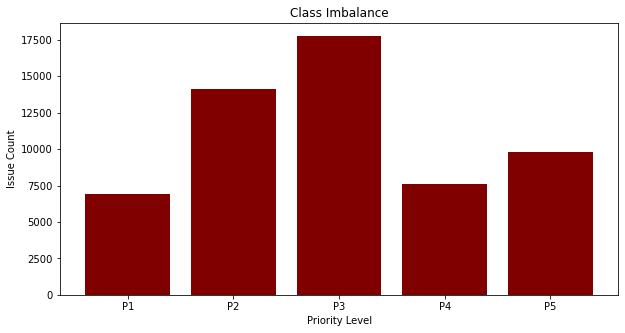

In [5]:
#plot to identyfy the class imbalance
def plot_class_imbalance(df):
    Priority = df['Priority'].values
    P1count = sum(Priority == 'P1')
    P2count = sum(Priority == 'P2')
    P3count = sum(Priority == 'P3')
    P4count = sum(Priority == 'P4')
    P5count = sum(Priority == 'P5')
    
    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(['P1', 'P2', 'P3', 'P4', 'P5'], 
            [P1count, P2count, P3count, P4count, P5count], 
            color ='maroon',
            width = 0.8
            )

    plt.xlabel("Priority Level")
    plt.ylabel("Issue Count")
    plt.title("Class Imbalance")
    plt.show()
    
plot_class_imbalance(df)

In [6]:
#Convert priority level in to numerical representation
class_dict = {
            'P1' : 0,
            'P2' : 1,
            'P3' : 2,
            'P4' : 3,
            'P5' : 4
                }
df = df.groupby('Priority').apply(lambda x: x.sample(25000,replace=True,random_state=seed))
df['Priority'] = df['Priority'].apply(lambda x: class_dict[x])

In [7]:
#split dataset to train and test
Summaries = df['Summary'].values
Priorities = df['Priority'].values

Summaries, Priorities = shuffle(Summaries, Priorities)

X, Xtest, Y, Ytest = train_test_split(
                                    Summaries, Priorities, 
                                    test_size = test_size, 
                                    random_state = seed)

In [8]:
#Function to providing class weights which is technique for handle class imbalance
class_weights = compute_class_weight(
                                'balanced',
                                 classes = np.unique(Y),
                                 y = Y)

'''

Eqn : Total Number of Samples / (2 * Number of Samples in Given Class)

'''
class_weights = {i : class_weights[i] for i in range(len(set(Y)))}                                                                                               
class_weights

{0: 0.9956892512416831,
 1: 0.9997647612326511,
 2: 1.0058695446369403,
 3: 0.9993886093213563,
 4: 0.9993416102332581}

In [9]:
#A comman Function to preprocess the data
def preprocess_one(x):
    '''
        Text preprocess on term text using above functions
    '''
    stopwords_list = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
        
    try:
        x = x.lower()
        x = tokenizer.tokenize(x) # Remove puntuations & Tokenization
        x = [token for token in x if token not in stopwords_list]
        x = [re.sub('[0-9]', '', i) for i in x] # Remove Numbers
        x = [i for i in x if len(i)>0] # Remove empty strings
        x = [lemmatizer.lemmatize(k) for k in x] # Word Lemmatization
        x = ' '.join(x)
        
    except:
        x = ''
        
    x = x.strip()
    return x                                                                                     

In [10]:
#function used to preprocess the data
def preprocessed_data(X):
    X = [preprocess_one(x) for x in X]
    return X

X = preprocessed_data(X)
Xtest = preprocessed_data(Xtest)

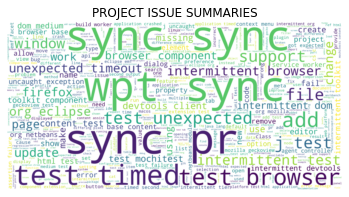

In [11]:
#visualized issue summaries
from wordcloud import WordCloud

long_string = ','.join(X + Xtest)
wordcloud = WordCloud(
                    width=3200, 
                    height=1600, 
                    max_words=500, 
                    background_color='white',
                    max_font_size=400,
                    random_state=seed
                    )
wordcloud.generate(long_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("PROJECT ISSUE SUMMARIES")
plt.show()

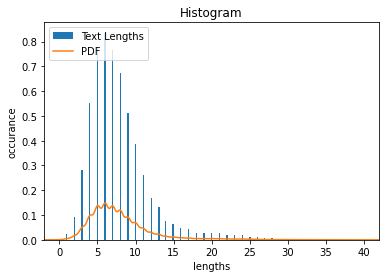

In [12]:
#the graph to identify (get and idea) max length
import scipy.stats as st

Xlen = np.array([len(sen.split()) for sen in X])
q25, q75 = np.percentile(Xlen,[25,75])
bin_width = 2*(q75 - q25)*len(Xlen)**(-1/3)
bins = int(round((Xlen.max() - Xlen.min())/bin_width))

plt.hist(Xlen, density=True, bins=bins, label="Text Lengths")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(Xlen)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('occurance')
plt.xlabel('lengths')
plt.title("Histogram")
plt.show()

# **Model PipeLine**

### ** GRU Model**
         - Tokenize & Pad Data
         - Define The RNN architecture
         - Compile & train the Model
         - Visualize Performance Metrices
         - Save & Load Model
         - Evaluation on test Set

In [13]:
Y = tf.keras.utils.to_categorical(Y, 5)
Ytest = tf.keras.utils.to_categorical(Ytest, 5)
max_length = 20
        
accuracy = tf.keras.metrics.CategoricalAccuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

#function to create and save word tokernization
def save_load_tokenizer():
    if not os.path.exists(tokenizer_path):
        tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>')
        tokenizer.fit_on_texts(X)
        
        with open(tokenizer_path, 'wb') as fp:
            pickle.dump(tokenizer, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
    else:
        with open(tokenizer_path, 'rb') as fp:
            tokenizer = pickle.load(fp)
            
    return tokenizer

#funtion to convert word tokernization
def handle_data():
    tokenizer = save_load_tokenizer()

    X_seq = tokenizer.texts_to_sequences(X) # tokenize train data
    X_pad = pad_sequences(
                        X_seq, 
                        maxlen=max_length, 
                        padding='pre', 
                        truncating='pre'
                        )# Pad Train data

    X_seq_test = tokenizer.texts_to_sequences(Xtest) # tokenize train data
    X_pad_test = pad_sequences(
                            X_seq_test, 
                            maxlen=max_length, 
                            padding='pre', 
                            truncating='pre'
                            )# Pad Train data

    return X_pad, X_pad_test, tokenizer ,  len(tokenizer.word_index) + 1

#Function used to repetitive block with different neurons 
def subnetwork(dense, x, last_block=False):
    if not last_block:
        x = Dense(dense)(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Dropout(0.2)(x)

    else:
        x = Dense(dense)(x)
        x = relu(x)
    return x

#model 
def classifier(vocab_size): 
    embedding_dim = 256
    inputs = Input(shape=(max_length,), name='text_inputs')
    x = Embedding(
                output_dim = embedding_dim, 
                input_dim = vocab_size, 
                input_length = max_length, 
                name = 'embedding'
                )(inputs) # Embedding layer
    x = Bidirectional(
                GRU(
                    256
                    ), name='gru'
                )(x)

    #call for subnetwork function with different dimention
    x = subnetwork(256, x)
    x = subnetwork(128, x)
    x = subnetwork(64, x, True)

    #classification 
    outputs = Dense(len(class_dict), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model

#plots to training and validate performance
def plot_metrics(history):
    binary_accuracy = history.history['categorical_accuracy']
    recall = history.history['recall']
    precision = history.history['precision']

    plt.plot(binary_accuracy, 'r', label='categorical accuracy')
    plt.plot(recall, 'b', label='recall')
    plt.plot(precision, 'g', label='precision')

    plt.title('Training Preformance')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    val_binary_accuracy = history.history['val_categorical_accuracy']
    val_recall = history.history['val_recall']
    val_precision = history.history['val_precision']

    plt.plot(val_binary_accuracy, 'r', label='val categorical accuracy')
    plt.plot(val_recall, 'b', label='val recall')
    plt.plot(val_precision, 'g', label='val precision')

    plt.title('Validation Preformance')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_categorical_accuracy') > 0.9 and logs.get('val_recall') > 0.9 and logs.get('val_precision') > 0.9):
            print("\nReached 90% validation accuracy.So stop training!")
            self.model.stop_training = True

            
# Compile the model and training

def train(model, X_pad, X_pad_test):
    callbacks = myCallback()

    model.compile(
                loss='categorical_crossentropy', 
                optimizer = Adam(learning_rate=0.001), 
                metrics=[
                        accuracy,
                        precision,
                        recall
                        ]
                     )
    history = model.fit(
                        X_pad,
                        Y,
                        batch_size = 64,
                        epochs = 10,
                        validation_split = val_size,
                        callbacks = [callbacks],
                        class_weight = class_weights
                        )
    plot_metrics(history)

# Save trained model    
def save_model(model):
    model.save(model_weights)

# Load and compile pretrained model    
def loaded_model(): 
    model = load_model(model_weights)
    model.compile(
                    loss='categorical_crossentropy', 
                    optimizer = Adam(learning_rate=0.001), 
                    metrics=[
                            accuracy,
                            precision,
                            recall
                            ]
                     )
    return model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_inputs (InputLayer)     [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 256)           6345984   
_________________________________________________________________
gru (Bidirectional)          (None, 512)               789504    
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 256)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 256)              

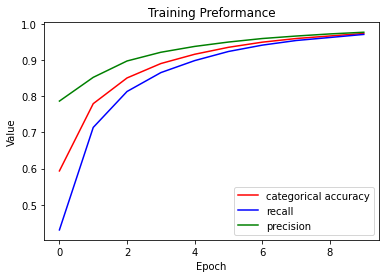

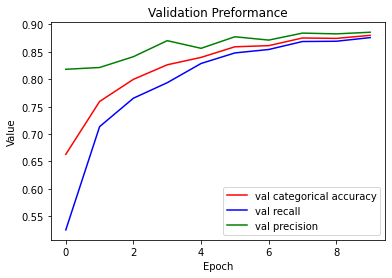

In [14]:
X_pad, X_pad_test, tokenizer, vocab_size = handle_data()
if not os.path.exists(model_weights):
    model = classifier(vocab_size)
    train(model, X_pad, X_pad_test)
    save_model(model) 
else:
    model = loaded_model()

In [15]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_pad_test, Ytest)

586/586 [==============================] - 10s 17ms/step - loss: 0.6178 - categorical_accuracy: 0.8845 - precision: 0.8901 - recall: 0.8808


In [16]:
print('Test Loss      : {}'.format(test_loss))
print('Test Accuracy  : {}'.format(test_acc))
print('Test Precision : {}'.format(test_precision))
print('Test Recall    : {}'.format(test_recall))

Test Loss      : 0.6178114414215088
Test Accuracy  : 0.8845333456993103
Test Precision : 0.8901045322418213
Test Recall    : 0.8808000087738037


### **3. Model Evaluation**

In [17]:
target_names = ['P1', 'P2', 'P3', 'P4', 'P5']
Ptest = model.predict(X_pad_test)

Ptest = np.argmax(Ptest, axis=-1)
Ytest_ = np.argmax(Ytest, axis=-1)                                                              

In [18]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(
                            Ytest_, 
                            Ptest, 
                            target_names=target_names
                            ))                                     

              precision    recall  f1-score   support

          P1       0.88      0.95      0.91      3658
          P2       0.87      0.77      0.82      3745
          P3       0.84      0.84      0.84      3874
          P4       0.91      0.93      0.92      3737
          P5       0.92      0.94      0.93      3736

    accuracy                           0.88     18750
   macro avg       0.88      0.89      0.88     18750
weighted avg       0.88      0.88      0.88     18750



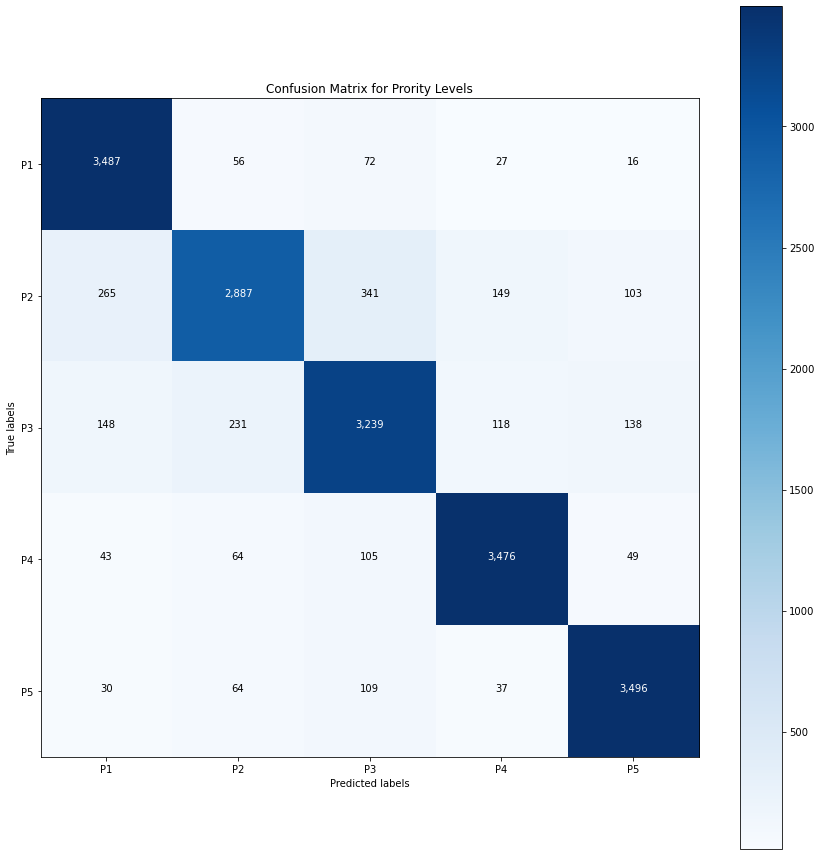

In [19]:
# Confusion Matrix 
import itertools
from sklearn.metrics import confusion_matrix

cmap, normalize = None, False
cm = confusion_matrix(Ytest_, Ptest)

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix for Prority Levels')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=0)
plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True labels')
plt.xlabel('Predicted labels')                                                                              
plt.show()

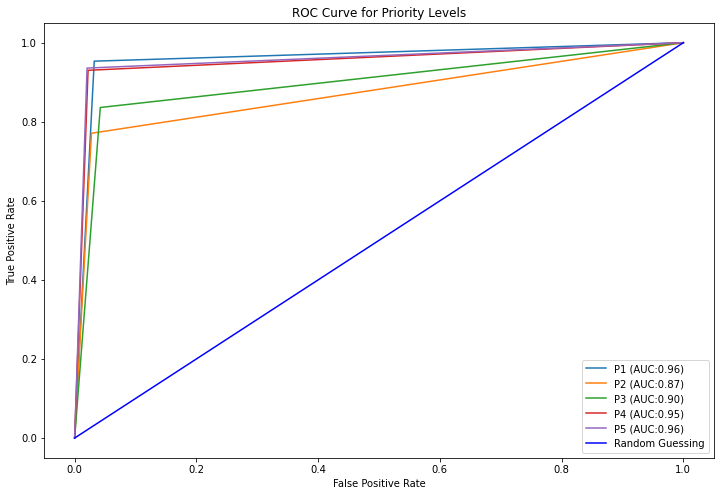

In [20]:
# ROC Curve
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

lb = LabelBinarizer()
lb.fit(Ytest_)
Ytest_ = lb.transform(Ytest_)
Ptest = lb.transform(Ptest)

for (idx, c_label) in enumerate(target_names):
    fpr, tpr, thresholds = roc_curve(Ytest_[:,idx].astype(int), Ptest[:,idx])

    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curve for Priority Levels')
plt.show()

### **4. Model Inference**

In [21]:
def inference(sample_text, tokenizer =tokenizer):
    text_processed = preprocess_one(sample_text)
    tokens = tokenizer.texts_to_sequences([text_processed]) # tokenize train data
    padded_tokens = pad_sequences(
                                tokens, 
                                maxlen=max_length, 
                                padding='pre', 
                                truncating='pre'
                                )
    
    P = model.predict(padded_tokens).squeeze()
    p = P.argmax()
    class_dict_rev = {v:k for k, v in class_dict.items()}
    return class_dict_rev[p]

In [22]:
sample_text = 'Set up alerts to track Phabricator Email failures'
priority_level = inference(sample_text)

In [23]:
priority_level

'P2'